In [1]:
#Importing the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import keras.backend as K
import tensorflow as tf
import tensorflow_probability as tfp
from keras.wrappers.scikit_learn import KerasRegressor
from keras import Model
from keras.models import Sequential, load_model
from keras.layers import Dense, SimpleRNN, Dropout, Lambda, LSTM, TimeDistributed, GRU, Bidirectional, Layer, Attention, AlphaDropout, Activation, Flatten, GlobalMaxPooling1D, Input, Multiply
from keras_self_attention import SeqSelfAttention
from keras.utils.generic_utils import get_custom_objects
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingRegressor
from math import sin
from scipy.linalg import expm
#import warnings
#warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Customers_in_a_Shop.csv', header=None)
df.head()

,0,1
0,1949-01,114.0
1,1949-02,120.0
2,1949-03,134.0
3,1949-04,67.0
4,1949-05,123.0


In [3]:
df.columns={"Date","Customers"}
print(df.isnull().sum())

Date         0
Customers    4
dtype: int64


In [4]:
df['Date'] = pd.to_datetime(df['Date'],format="%Y-%m")
df = df.set_index('Date')
df

,Customers
Date,
1949-01-01,114.0
1949-02-01,120.0
1949-03-01,134.0
1949-04-01,67.0
1949-05-01,123.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,720.0


In [5]:
missing = df[df.isna().any(axis=1)]
print(missing)

            Customers
Date                 
1951-06-01        NaN
1951-07-01        NaN
1954-06-01        NaN
1960-03-01        NaN


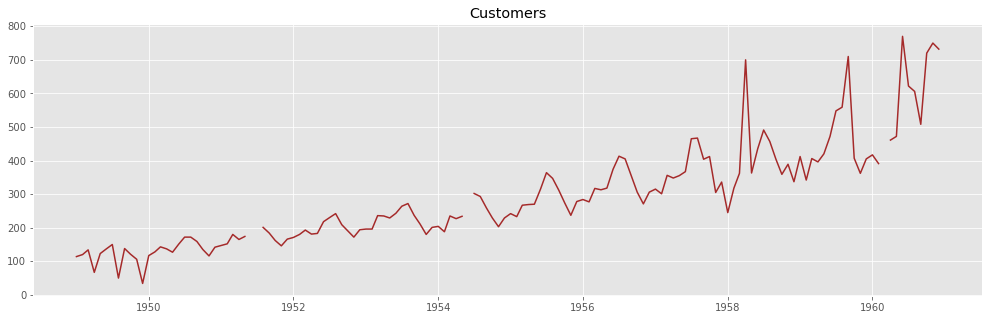

In [6]:
#from matplotlib import style
#print(plt.style.available)

plt.style.use('ggplot')
plt.rcParams['figure.figsize']=(17,5)

plt.plot(df, color='brown')
plt.title("Customers")
plt.show()

## Imputing missing values

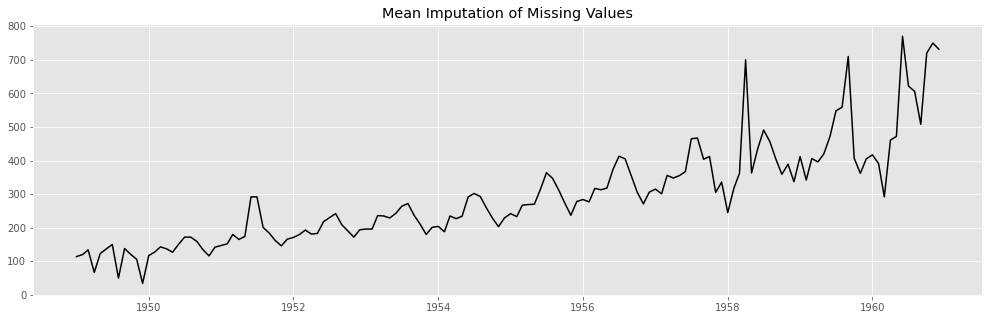

In [7]:
## Comparing several types of interpolations - mean 
plt.rcParams['figure.figsize']=(17,5)
df['Customers_mean'] = df['Customers'].fillna(df['Customers'].mean())
plt.plot(df['Customers_mean'],color='black')
plt.title("Mean Imputation of Missing Values")
plt.show()

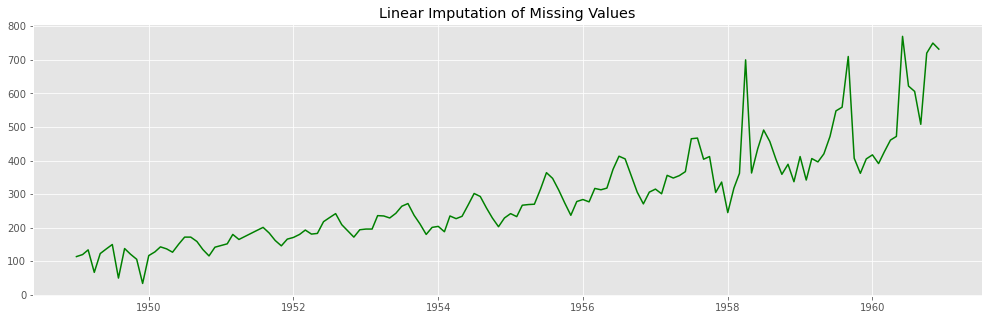

In [8]:
## Comparing several types of interpolations - linear
plt.rcParams['figure.figsize']=(17,5)
df['Customers_linear'] = df['Customers'].interpolate(method='linear')
plt.plot(df['Customers_linear'],color='green')
plt.title("Linear Imputation of Missing Values")
plt.show()

In [9]:
df1 = df['1949-06':'1960-06':12]
df1

,Customers,Customers_mean,Customers_linear
Date,,,
1949-06-01,137.0,137.000000,137.0
1950-06-01,151.0,151.000000,151.0
1951-06-01,NaN,291.878571,183.0
1952-06-01,218.0,218.000000,218.0
1953-06-01,243.0,243.000000,243.0
1954-06-01,NaN,291.878571,268.0
1955-06-01,315.0,315.000000,315.0
1956-06-01,374.0,374.000000,374.0
1957-06-01,367.0,367.000000,367.0


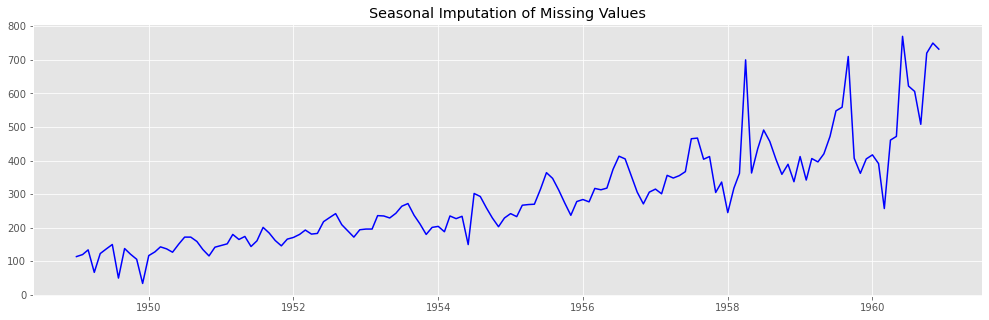

In [10]:
## Comparing several types of interpolations - seasonal interpolation
df.loc['1960-03'].fillna((df['1949-03':'1959-03':12].sum())/df['1949-03':'1959-03':12].shape[0], inplace=True)
df.loc['1954-06'].fillna((df['1949-06':'1953-06':12].sum())/(df['1949-06':'1953-06':12].shape[0]), inplace=True)
df.loc['1951-07'].fillna((df['1949-07':'1950-07':12].sum())/(df.loc['1949-07':'1950-07':12].shape[0]), inplace=True)
df.loc['1951-06'].fillna((df['1949-06':'1950-06':12].sum())/(df['1949-06':'1950-06':12].shape[0]), inplace=True)

plt.rcParams['figure.figsize']=(17,5)
plt.plot(df['Customers'],color='blue')
plt.title("Seasonal Imputation of Missing Values")
plt.show()

In [11]:
df['Customers'].sort_values(ascending=False).head(7)

Date
1960-06-01    770.0
1960-11-01    750.0
1960-12-01    732.0
1960-10-01    720.0
1959-09-01    710.0
1958-04-01    700.0
1960-07-01    622.0
Name: Customers, dtype: float64

## Normality plots 

/home/ardavan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Customers', ylabel='Density'>

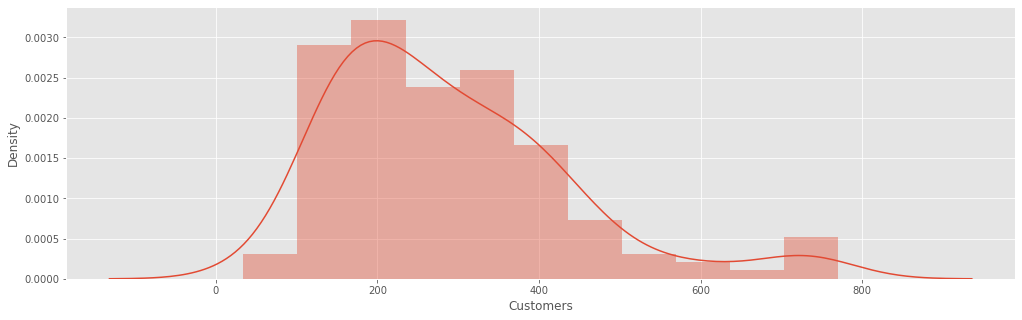

In [12]:
sns.distplot(df['Customers'])

((array([-2.58977345, -2.26833208, -2.08397164, -1.95134078, -1.84615093,
         -1.75813779, -1.68195358, -1.61444188, -1.55357684, -1.49797725,
         -1.44665728, -1.39888755, -1.35411252, -1.31189888, -1.27190175,
         -1.23384196, -1.19749012, -1.16265539, -1.12917712, -1.09691879,
         -1.06576327, -1.03560932, -1.00636876, -0.97796428, -0.95032771,
         -0.92339857, -0.89712296, -0.87145259, -0.84634402, -0.82175802,
         -0.797659  , -0.77401457, -0.75079515, -0.72797364, -0.70552513,
         -0.68342667, -0.66165704, -0.64019656, -0.61902697, -0.59813124,
         -0.57749349, -0.55709882, -0.53693331, -0.51698381, -0.49723799,
         -0.47768418, -0.45831134, -0.43910901, -0.42006725, -0.40117661,
         -0.38242807, -0.36381301, -0.34532319, -0.32695068, -0.30868788,
         -0.29052747, -0.27246238, -0.25448578, -0.23659106, -0.21877178,
         -0.2010217 , -0.18333474, -0.16570495, -0.14812651, -0.13059373,
         -0.11310101, -0.09564283, -0.

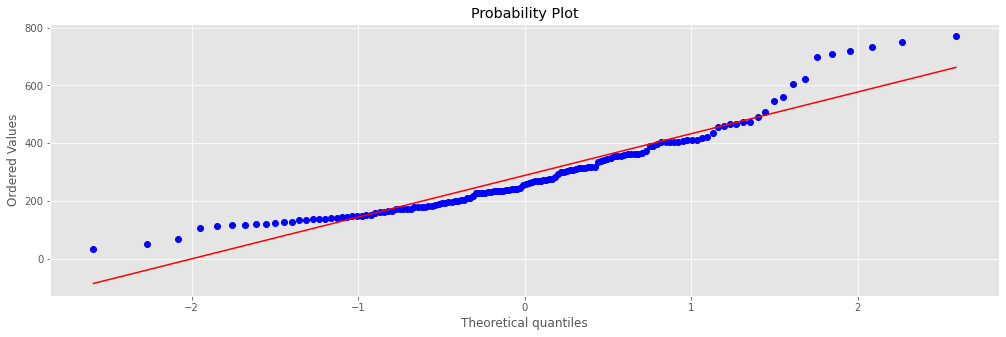

In [13]:
import scipy.stats
import pylab 
scipy.stats.probplot(df['Customers'],plot=pylab)
# pylab.show()

# Y-Axis: Data Value
# X-Axis: 

# Naive Decomposition
### Additive Seasonal Decomposition

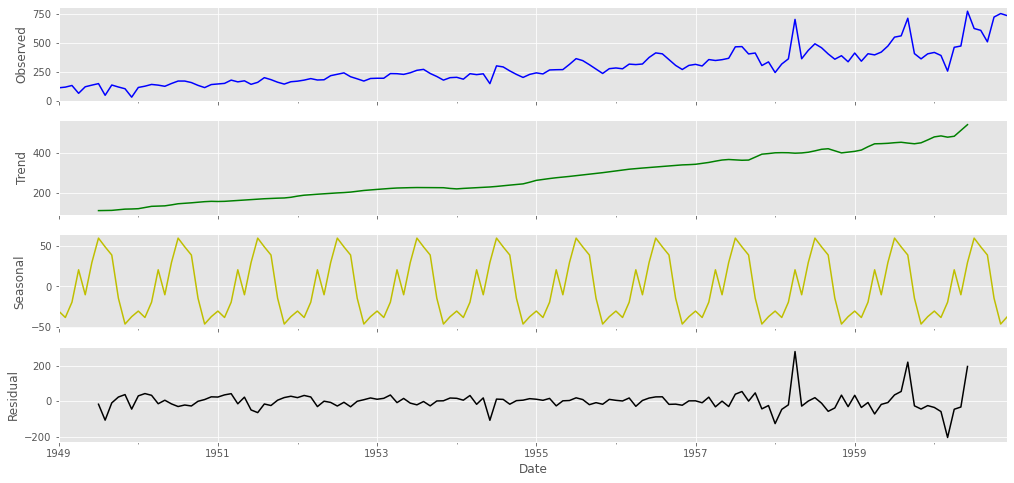

In [14]:
import statsmodels.api as sm

plt.rcParams['figure.figsize'] = (17,8)

decomposition = sm.tsa.seasonal_decompose(df['Customers'], model='additive')
#decomposition.plot()

fig, axes = plt.subplots(4, 1, sharex=True)

decomposition.observed.plot(ax=axes[0], legend=False, color='b')
axes[0].set_ylabel('Observed')
decomposition.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')
decomposition.seasonal.plot(ax=axes[2], legend=False, color='y')
axes[2].set_ylabel('Seasonal')
decomposition.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')                           
plt.show()

### Multiplicative Seasonal Decomposition

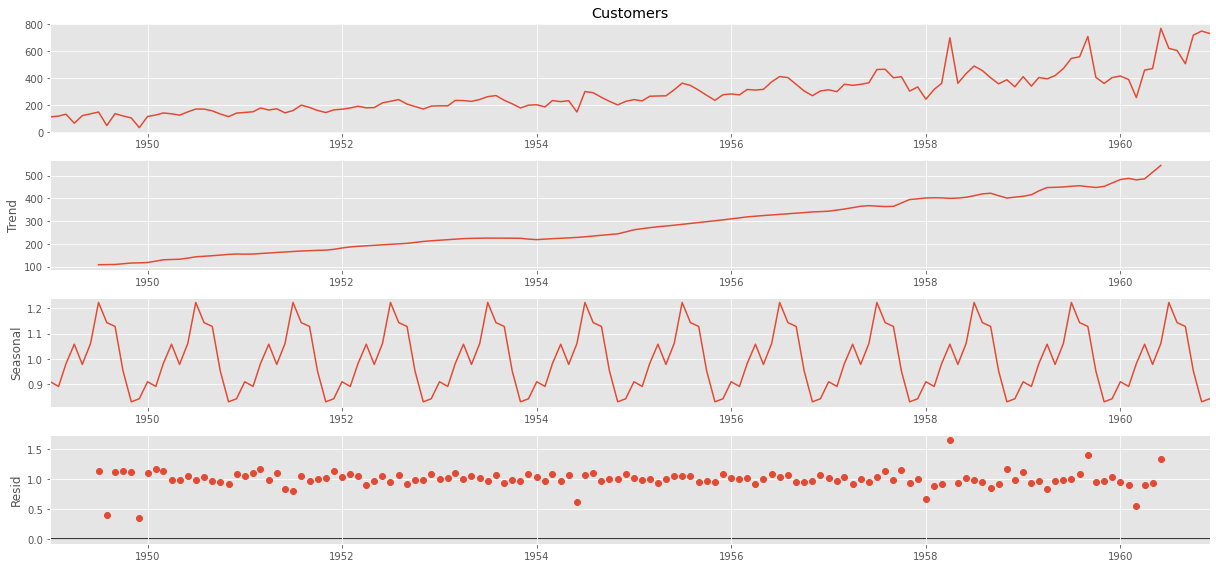

In [15]:
import statsmodels.api as sm
plt.rcParams['figure.figsize'] = (17,8)

decomposition = sm.tsa.seasonal_decompose(df['Customers'], model='multiplicative')
fig = decomposition.plot()
plt.show()

## Splitting Train and Test data

In [16]:
length = int(np.round(len(df["Customers_linear"])*0.8))
print(length)

115


In [17]:
df.drop(columns=["Customers_mean","Customers_linear"], inplace=True)
df.index.freq = 'MS'

In [18]:
## iF removing of the index is needed.
#df.reset_index(drop=True, inplace=True)
#df

In [19]:
train = df.iloc[:length,:]
train

,Customers
Date,
1949-01-01,114.0
1949-02-01,120.0
1949-03-01,134.0
1949-04-01,67.0
1949-05-01,123.0
...,...
1958-03-01,362.0
1958-04-01,700.0
1958-05-01,363.0


In [20]:
test = df.iloc[length:,: ]
test

,Customers
Date,
1958-08-01,457.000000
1958-09-01,404.000000
1958-10-01,359.000000
1958-11-01,389.000000
1958-12-01,337.000000
1959-01-01,412.000000
1959-02-01,342.000000
1959-03-01,406.000000
1959-04-01,396.000000


In [21]:
print(test.shape)
print(train.shape)

(29, 1)
(115, 1)


In [22]:
SC = StandardScaler()
train = SC.fit_transform(train)
test = SC.transform(test)
train

array([[-1.21245702],
       [-1.15425422],
       [-1.0184477 ],
       [-1.66837891],
       [-1.12515282],
       [-0.9893463 ],
       [-0.86324024],
       [-1.83328683],
       [-0.97964583],
       [-1.14455375],
       [-1.29006074],
       [-1.98849429],
       [-1.18335562],
       [-1.07665049],
       [-0.9311435 ],
       [-0.9893463 ],
       [-1.08635096],
       [-0.85353978],
       [-0.64982999],
       [-0.64982999],
       [-0.77593605],
       [-1.00874723],
       [-1.19305608],
       [-0.94084397],
       [-0.89234164],
       [-0.84383931],
       [-0.57222627],
       [-0.71773325],
       [-0.63042906],
       [-0.92144304],
       [-0.75653512],
       [-0.36851648],
       [-0.5334244 ],
       [-0.74683465],
       [-0.90204211],
       [-0.70803279],
       [-0.65953046],
       [-0.57222627],
       [-0.44612021],
       [-0.5625258 ],
       [-0.54312487],
       [-0.20360856],
       [-0.08720297],
       [ 0.02920262],
       [-0.29091276],
       [-0

### Change Data to RNN Architecture

In [23]:
stepsize = 18 #Should be optimized!

def RNN_Structure(df, stepsize):
    X =[]
    Y =[]
    
    for n in range(len(df) - stepsize):
        z = n + stepsize
        X.append(df[n:z,]) #sample =10
        Y.append(df[z,])   #sample = 11 is your label
        
    return np.array(X) , np.array(Y)

        
X_train ,Y_train =  RNN_Structure(train, stepsize)
X_test  , Y_test =  RNN_Structure(test, stepsize)

In [24]:
print(X_train.shape) # X_train value with step = 10
print(X_test.shape)  # X_Test value with step = 10
print(Y_train.shape) # X_train value with step = 10
print(Y_test.shape)  # X_Test value with step = 10

(97, 18, 1)
(11, 18, 1)
(97, 1)
(11, 1)


* First Argument: Sample size
* Second Argument: Time Step
* Third Argument: Number of Feature

**(Sample size, Step Lenght/Sequence Lenght, Number of Input Feature/ Input Value to RNN)**

In [25]:
## Not necessary for this series, since already done in the previous definition function. But in case:

# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# print(X_train.shape)
# print(X_test.shape)

In [26]:
X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
Y_train = np.asarray(Y_train).astype(np.float32)
Y_test = np.asarray(Y_test).astype(np.float32)

In [27]:
df.reset_index(inplace=True, drop=True)
df

,Customers
0,114.0
1,120.0
2,134.0
3,67.0
4,123.0
...,...
139,606.0
140,508.0
141,720.0
142,750.0


### Simple RNN

In [28]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [32]:
inputs = Input(shape=[18,1])

initializer = tf.keras.initializers.variance_scaling(scale=1, mode="fan_avg")
initializer2 = tf.keras.initializers.lecun_normal(seed=262)

x1 = SimpleRNN(units=32, return_sequences=False ,kernel_initializer=initializer)(inputs)
x2 = GRU(units=32, return_sequences=False, kernel_initializer=initializer2)(inputs)
x3 = x1 + K.reverse(x1, 1) + K.reverse(x2, 1) + x2 
x4 = Dense(units = 32, activation="LeakyReLU")(x3)
outputs = Dense(1, "LeakyReLU", input_shape=[x4.shape])(x4) 

RNN = Model(inputs=inputs, outputs=outputs, name="simpleRNN")
RNN.compile(loss="mse", optimizer="nadam", metrics=["mse", "logcosh", coeff_determination])
memory = RNN.fit(X_train, Y_train, batch_size = 20, epochs=500, use_multiprocessing=True)

Epoch 1/500
5/5 [==============================] - 2s 7ms/step - loss: 1.0018 - mse: 1.0018 - logcosh: 0.3365 - coeff_determination: -0.1919
Epoch 2/500
5/5 [==============================] - 0s 6ms/step - loss: 0.5136 - mse: 0.5136 - logcosh: 0.1799 - coeff_determination: 0.4167
Epoch 3/500
5/5 [==============================] - 0s 6ms/step - loss: 0.2622 - mse: 0.2622 - logcosh: 0.1008 - coeff_determination: 0.6870
Epoch 4/500
5/5 [==============================] - 0s 6ms/step - loss: 0.2526 - mse: 0.2526 - logcosh: 0.1002 - coeff_determination: 0.6492
Epoch 5/500
5/5 [==============================] - 0s 6ms/step - loss: 0.2217 - mse: 0.2217 - logcosh: 0.0850 - coeff_determination: 0.7938
Epoch 6/500
5/5 [==============================] - 0s 7ms/step - loss: 0.2091 - mse: 0.2091 - logcosh: 0.0801 - coeff_determination: 0.7720
Epoch 7/500
5/5 [==============================] - 0s 6ms/step - loss: 0.2018 - mse: 0.2018 - logcosh: 0.0768 - coeff_determination: 0.7859
Epoch 8/500
5/5 [==

5/5 [==============================] - 0s 6ms/step - loss: 0.0377 - mse: 0.0377 - logcosh: 0.0183 - coeff_determination: 0.9513
Epoch 60/500
5/5 [==============================] - 0s 5ms/step - loss: 0.0358 - mse: 0.0358 - logcosh: 0.0174 - coeff_determination: 0.9514
Epoch 61/500
5/5 [==============================] - 0s 6ms/step - loss: 0.0329 - mse: 0.0329 - logcosh: 0.0159 - coeff_determination: 0.9471
Epoch 62/500
5/5 [==============================] - 0s 6ms/step - loss: 0.0323 - mse: 0.0323 - logcosh: 0.0156 - coeff_determination: 0.9553
Epoch 63/500
5/5 [==============================] - 0s 6ms/step - loss: 0.0318 - mse: 0.0318 - logcosh: 0.0154 - coeff_determination: 0.9343
Epoch 64/500
5/5 [==============================] - 0s 6ms/step - loss: 0.0324 - mse: 0.0324 - logcosh: 0.0157 - coeff_determination: 0.9495
Epoch 65/500
5/5 [==============================] - 0s 6ms/step - loss: 0.0335 - mse: 0.0335 - logcosh: 0.0162 - coeff_determination: 0.9547
Epoch 66/500
5/5 [========

5/5 [==============================] - 0s 5ms/step - loss: 0.0193 - mse: 0.0193 - logcosh: 0.0093 - coeff_determination: 0.9726
Epoch 118/500
5/5 [==============================] - 0s 5ms/step - loss: 0.0195 - mse: 0.0195 - logcosh: 0.0094 - coeff_determination: 0.9727
Epoch 119/500
5/5 [==============================] - 0s 5ms/step - loss: 0.0230 - mse: 0.0230 - logcosh: 0.0112 - coeff_determination: 0.9672
Epoch 120/500
5/5 [==============================] - 0s 5ms/step - loss: 0.0189 - mse: 0.0189 - logcosh: 0.0092 - coeff_determination: 0.9656
Epoch 121/500
5/5 [==============================] - 0s 5ms/step - loss: 0.0188 - mse: 0.0188 - logcosh: 0.0091 - coeff_determination: 0.9731
Epoch 122/500
5/5 [==============================] - 0s 6ms/step - loss: 0.0198 - mse: 0.0198 - logcosh: 0.0096 - coeff_determination: 0.9605
Epoch 123/500
5/5 [==============================] - 0s 6ms/step - loss: 0.0190 - mse: 0.0190 - logcosh: 0.0092 - coeff_determination: 0.9695
Epoch 124/500
5/5 [=

5/5 [==============================] - 0s 5ms/step - loss: 0.0142 - mse: 0.0142 - logcosh: 0.0069 - coeff_determination: 0.9779
Epoch 175/500
5/5 [==============================] - 0s 6ms/step - loss: 0.0141 - mse: 0.0141 - logcosh: 0.0069 - coeff_determination: 0.9788
Epoch 176/500
5/5 [==============================] - 0s 6ms/step - loss: 0.0190 - mse: 0.0190 - logcosh: 0.0093 - coeff_determination: 0.9689
Epoch 177/500
5/5 [==============================] - 0s 6ms/step - loss: 0.0154 - mse: 0.0154 - logcosh: 0.0075 - coeff_determination: 0.9771
Epoch 178/500
5/5 [==============================] - 0s 5ms/step - loss: 0.0154 - mse: 0.0154 - logcosh: 0.0075 - coeff_determination: 0.9768
Epoch 179/500
5/5 [==============================] - 0s 5ms/step - loss: 0.0141 - mse: 0.0141 - logcosh: 0.0068 - coeff_determination: 0.9801
Epoch 180/500
5/5 [==============================] - 0s 5ms/step - loss: 0.0178 - mse: 0.0178 - logcosh: 0.0086 - coeff_determination: 0.9759
Epoch 181/500
5/5 [=

5/5 [==============================] - 0s 6ms/step - loss: 0.0118 - mse: 0.0118 - logcosh: 0.0058 - coeff_determination: 0.9857
Epoch 232/500
5/5 [==============================] - 0s 6ms/step - loss: 0.0108 - mse: 0.0108 - logcosh: 0.0053 - coeff_determination: 0.9682
Epoch 233/500
5/5 [==============================] - 0s 6ms/step - loss: 0.0143 - mse: 0.0143 - logcosh: 0.0070 - coeff_determination: 0.9830
Epoch 234/500
5/5 [==============================] - 0s 6ms/step - loss: 0.0113 - mse: 0.0113 - logcosh: 0.0055 - coeff_determination: 0.9832
Epoch 235/500
5/5 [==============================] - 0s 5ms/step - loss: 0.0123 - mse: 0.0123 - logcosh: 0.0060 - coeff_determination: 0.9810
Epoch 236/500
5/5 [==============================] - 0s 5ms/step - loss: 0.0115 - mse: 0.0115 - logcosh: 0.0056 - coeff_determination: 0.9828
Epoch 237/500
5/5 [==============================] - 0s 6ms/step - loss: 0.0118 - mse: 0.0118 - logcosh: 0.0058 - coeff_determination: 0.9612
Epoch 238/500
5/5 [=

5/5 [==============================] - 0s 6ms/step - loss: 0.0094 - mse: 0.0094 - logcosh: 0.0046 - coeff_determination: 0.9861
Epoch 289/500
5/5 [==============================] - 0s 5ms/step - loss: 0.0090 - mse: 0.0090 - logcosh: 0.0044 - coeff_determination: 0.9871
Epoch 290/500
5/5 [==============================] - 0s 5ms/step - loss: 0.0139 - mse: 0.0139 - logcosh: 0.0068 - coeff_determination: 0.9806
Epoch 291/500
5/5 [==============================] - 0s 6ms/step - loss: 0.0104 - mse: 0.0104 - logcosh: 0.0051 - coeff_determination: 0.9845
Epoch 292/500
5/5 [==============================] - 0s 6ms/step - loss: 0.0104 - mse: 0.0104 - logcosh: 0.0051 - coeff_determination: 0.9844
Epoch 293/500
5/5 [==============================] - 0s 6ms/step - loss: 0.0089 - mse: 0.0089 - logcosh: 0.0044 - coeff_determination: 0.9888
Epoch 294/500
5/5 [==============================] - 0s 5ms/step - loss: 0.0089 - mse: 0.0089 - logcosh: 0.0044 - coeff_determination: 0.9866
Epoch 295/500
5/5 [=

5/5 [==============================] - 0s 6ms/step - loss: 0.0066 - mse: 0.0066 - logcosh: 0.0033 - coeff_determination: 0.9911
Epoch 346/500
5/5 [==============================] - 0s 6ms/step - loss: 0.0065 - mse: 0.0065 - logcosh: 0.0032 - coeff_determination: 0.9881
Epoch 347/500
5/5 [==============================] - 0s 6ms/step - loss: 0.0079 - mse: 0.0079 - logcosh: 0.0039 - coeff_determination: 0.9834
Epoch 348/500
5/5 [==============================] - 0s 6ms/step - loss: 0.0119 - mse: 0.0119 - logcosh: 0.0059 - coeff_determination: 0.9840
Epoch 349/500
5/5 [==============================] - 0s 6ms/step - loss: 0.0116 - mse: 0.0116 - logcosh: 0.0058 - coeff_determination: 0.9783
Epoch 350/500
5/5 [==============================] - 0s 5ms/step - loss: 0.0107 - mse: 0.0107 - logcosh: 0.0053 - coeff_determination: 0.9854
Epoch 351/500
5/5 [==============================] - 0s 5ms/step - loss: 0.0072 - mse: 0.0072 - logcosh: 0.0036 - coeff_determination: 0.9888
Epoch 352/500
5/5 [=

5/5 [==============================] - 0s 6ms/step - loss: 0.0048 - mse: 0.0048 - logcosh: 0.0024 - coeff_determination: 0.9932
Epoch 403/500
5/5 [==============================] - 0s 6ms/step - loss: 0.0051 - mse: 0.0051 - logcosh: 0.0025 - coeff_determination: 0.9924
Epoch 404/500
5/5 [==============================] - 0s 5ms/step - loss: 0.0059 - mse: 0.0059 - logcosh: 0.0029 - coeff_determination: 0.9919
Epoch 405/500
5/5 [==============================] - 0s 5ms/step - loss: 0.0056 - mse: 0.0056 - logcosh: 0.0028 - coeff_determination: 0.9863
Epoch 406/500
5/5 [==============================] - 0s 6ms/step - loss: 0.0050 - mse: 0.0050 - logcosh: 0.0025 - coeff_determination: 0.9921
Epoch 407/500
5/5 [==============================] - 0s 6ms/step - loss: 0.0055 - mse: 0.0055 - logcosh: 0.0027 - coeff_determination: 0.9903
Epoch 408/500
5/5 [==============================] - 0s 6ms/step - loss: 0.0053 - mse: 0.0053 - logcosh: 0.0027 - coeff_determination: 0.9912
Epoch 409/500
5/5 [=

5/5 [==============================] - 0s 6ms/step - loss: 0.0028 - mse: 0.0028 - logcosh: 0.0014 - coeff_determination: 0.9960
Epoch 460/500
5/5 [==============================] - 0s 6ms/step - loss: 0.0028 - mse: 0.0028 - logcosh: 0.0014 - coeff_determination: 0.9965
Epoch 461/500
5/5 [==============================] - 0s 5ms/step - loss: 0.0023 - mse: 0.0023 - logcosh: 0.0011 - coeff_determination: 0.9966
Epoch 462/500
5/5 [==============================] - 0s 5ms/step - loss: 0.0030 - mse: 0.0030 - logcosh: 0.0015 - coeff_determination: 0.9953        
Epoch 463/500
5/5 [==============================] - 0s 5ms/step - loss: 0.0028 - mse: 0.0028 - logcosh: 0.0014 - coeff_determination: 0.9949        
Epoch 464/500
5/5 [==============================] - 0s 5ms/step - loss: 0.0031 - mse: 0.0031 - logcosh: 0.0015 - coeff_determination: 0.9960
Epoch 465/500
5/5 [==============================] - 0s 5ms/step - loss: 0.0082 - mse: 0.0082 - logcosh: 0.0041 - coeff_determination: 0.9870
Epoc

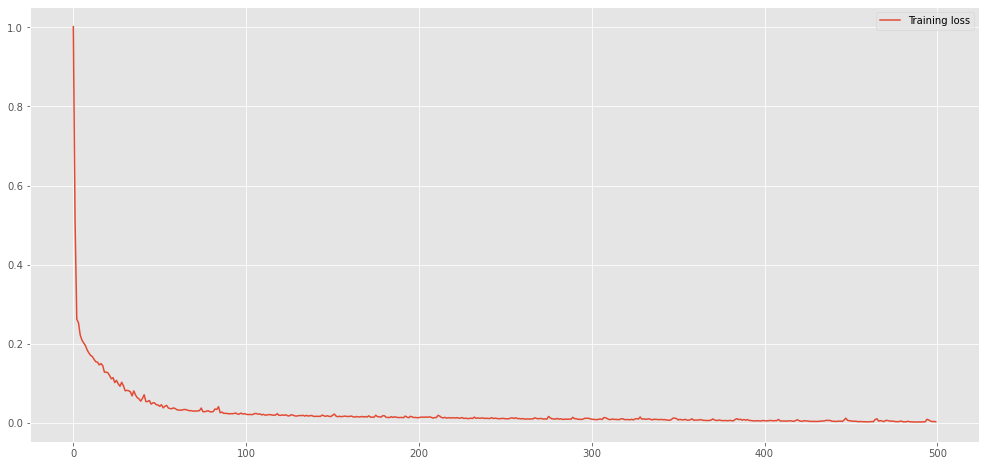

In [33]:
Loss_func = memory.history["loss"]
plt.plot(Loss_func, label= "Training loss")
plt.legend()

In [34]:
pred_train = SC.inverse_transform(RNN.predict(X_train.squeeze(axis=2)))
pred_test = SC.inverse_transform(RNN.predict(X_test.squeeze(axis=2)))

pred = pd.DataFrame(np.concatenate((pred_train,pred_test), axis = 0))

In [35]:
pred

,0
0,172.187454
1,174.089096
2,157.639420
3,136.246048
4,119.341614
...,...
103,494.439636
104,472.842010
105,408.601288
106,325.945770


<function matplotlib.pyplot.show(close=None, block=None)>

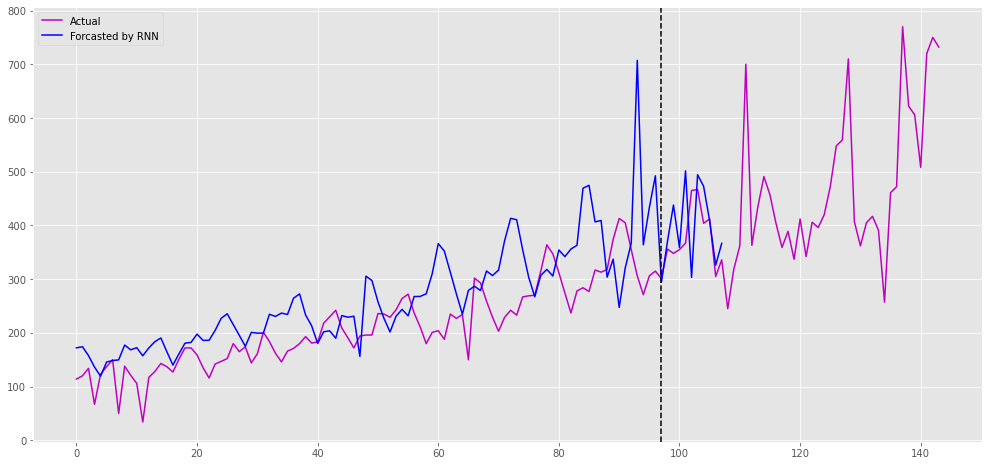

In [37]:
plt.plot(df, color="m")
plt.plot(pred, color="blue")
plt.legend(["Actual","Forcasted by RNN"])
plt.axvline(len(X_train), c= "k", linestyle='dashed')
plt.show

In [38]:
RNN.summary()

Model: "simpleRNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 18, 1)]      0           []                               
                                                                                                  
 simple_rnn_1 (SimpleRNN)       (None, 32)           1088        ['input_2[0][0]']                
                                                                                                  
 tf.reverse_2 (TFOpLambda)      (None, 32)           0           ['simple_rnn_1[0][0]']           
                                                                                                  
 gru_1 (GRU)                    (None, 32)           3360        ['input_2[0][0]']                
                                                                                          

In [39]:
score = RNN.evaluate(X_train, Y_train, verbose = 0)
score #Customized loss

[0.002012473763898015,
 0.002012473763898015,
 0.0010045766830444336,
 -462.282958984375]